# von Karman vortex street


In [6]:
import numpy as np
import seaborn as sns
import torch
import torch_cfd.finite_differences as fdm
import xarray
import math
from torch_cfd import advection, boundaries, grids
import torch_cfd.finite_differences as fdm

from torch_cfd.fvm import NavierStokes2DFVMProjection, PressureProjection, RKStepper
from torch_cfd.initial_conditions import velocity_field
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
nx = 400
ny = 200
density = 1.0
dt = 1e-3
batch_size = 8
viscosity = 1 / 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
T = 20
num_steps = int(T / dt)
update_steps = 100
domain = ((0, 2), (0, 1))

center = (0.45, 0.5)
radius = 0.1

grid = grids.Grid((nx, ny), domain=domain, device=device)

velocity_bc, pressure_bc = boundaries.karman_vortex_boundary_conditions(grid, cylinder_center=center, cylinder_radius=radius)


x_velocity_fn = lambda x, y: torch.ones_like(x)
y_velocity_fn = lambda x, y: torch.zeros_like(x)

v0 = velocity_field(
    (x_velocity_fn, y_velocity_fn),
    grid,
    velocity_bc=velocity_bc,
    batch_size=batch_size,
    random_state=42,
    noise=0.1,
    device=device,
)

pressure_proj = PressureProjection(
    grid=grid, bc=pressure_bc, dtype=dtype, implementation="matmul"
)

v = v0

convection = advection.ConvectionVector(
    grid=grid,
    offsets=(v0[0].offset, v0[1].offset),
    bcs=velocity_bc,
    advect=advection.AdvectionVanLeer,
)


step_fn = RKStepper.from_method(method="classic_rk4", requires_grad=False, dtype=dtype)

ns2d = NavierStokes2DFVMProjection(
    viscosity=viscosity,
    grid=grid,
    bcs=velocity_bc,
    density=density,
    step_fn=step_fn,
    pressure_proj=pressure_proj,
    convection=convection,
).to(v0.device)


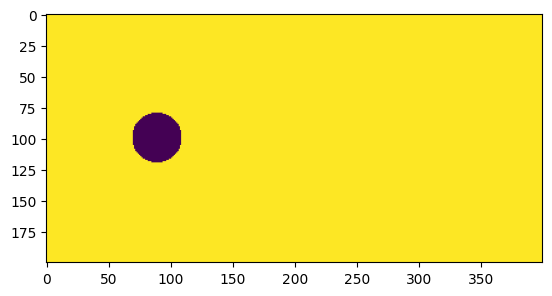

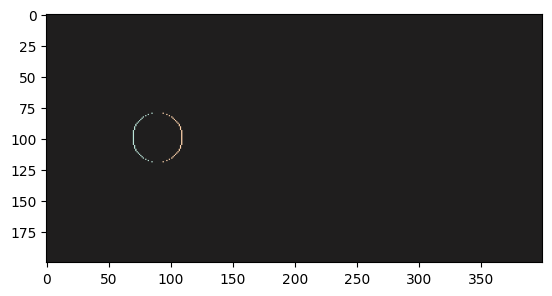

In [3]:
velocity_norm = torch.sqrt(v[0].L2norm ** 2 + v[1].L2norm ** 2)
divergence = fdm.divergence(v)

plt.imshow(velocity_bc[0].mask.data.cpu().numpy().T)
plt.show()

plt.imshow(divergence.data[0].cpu().numpy().T, cmap=sns.cm.icefire)
plt.show()

In [4]:
trajectory = [[], []]
nan_count = 0
velocity_norm = torch.sqrt(v[0].L2norm ** 2 + v[1].L2norm ** 2)
divergence = fdm.divergence(v)
desc = f"u norm: {velocity_norm.mean().item():.3e} | div norm: {divergence.L2norm.mean().item():.3e}"

with tqdm(total=num_steps, desc=desc) as pbar:
    with torch.no_grad():
        for i in range(num_steps):
            v, p = ns2d(v, dt)
            if torch.isnan(v[0].data).any():
                print(f"NaN detected at step {i}")
                nan_count += 1
                break

            if i % update_steps == 0:
                velocity_norm = torch.sqrt(v[0].L2norm ** 2 + v[1].L2norm ** 2)
                divergence = fdm.divergence(v)
                desc = f"u norm: {velocity_norm.mean().item():.3e} | div norm: {divergence.L2norm.mean().item():.3e}"
                if nan_count > 0:
                    break
                trajectory[0].append(v[0].data.detach().cpu().numpy())
                trajectory[1].append(v[1].data.detach().cpu().numpy())

                pbar.set_description(desc)
                pbar.update(update_steps)

u norm: 1.421e+00 | div norm: 5.337e+00:   0%|          | 100/20000 [00:00<00:25, 778.19it/s]

u norm: 1.268e+00 | div norm: 4.956e-01: 100%|██████████| 20000/20000 [19:30<00:00, 17.09it/s]


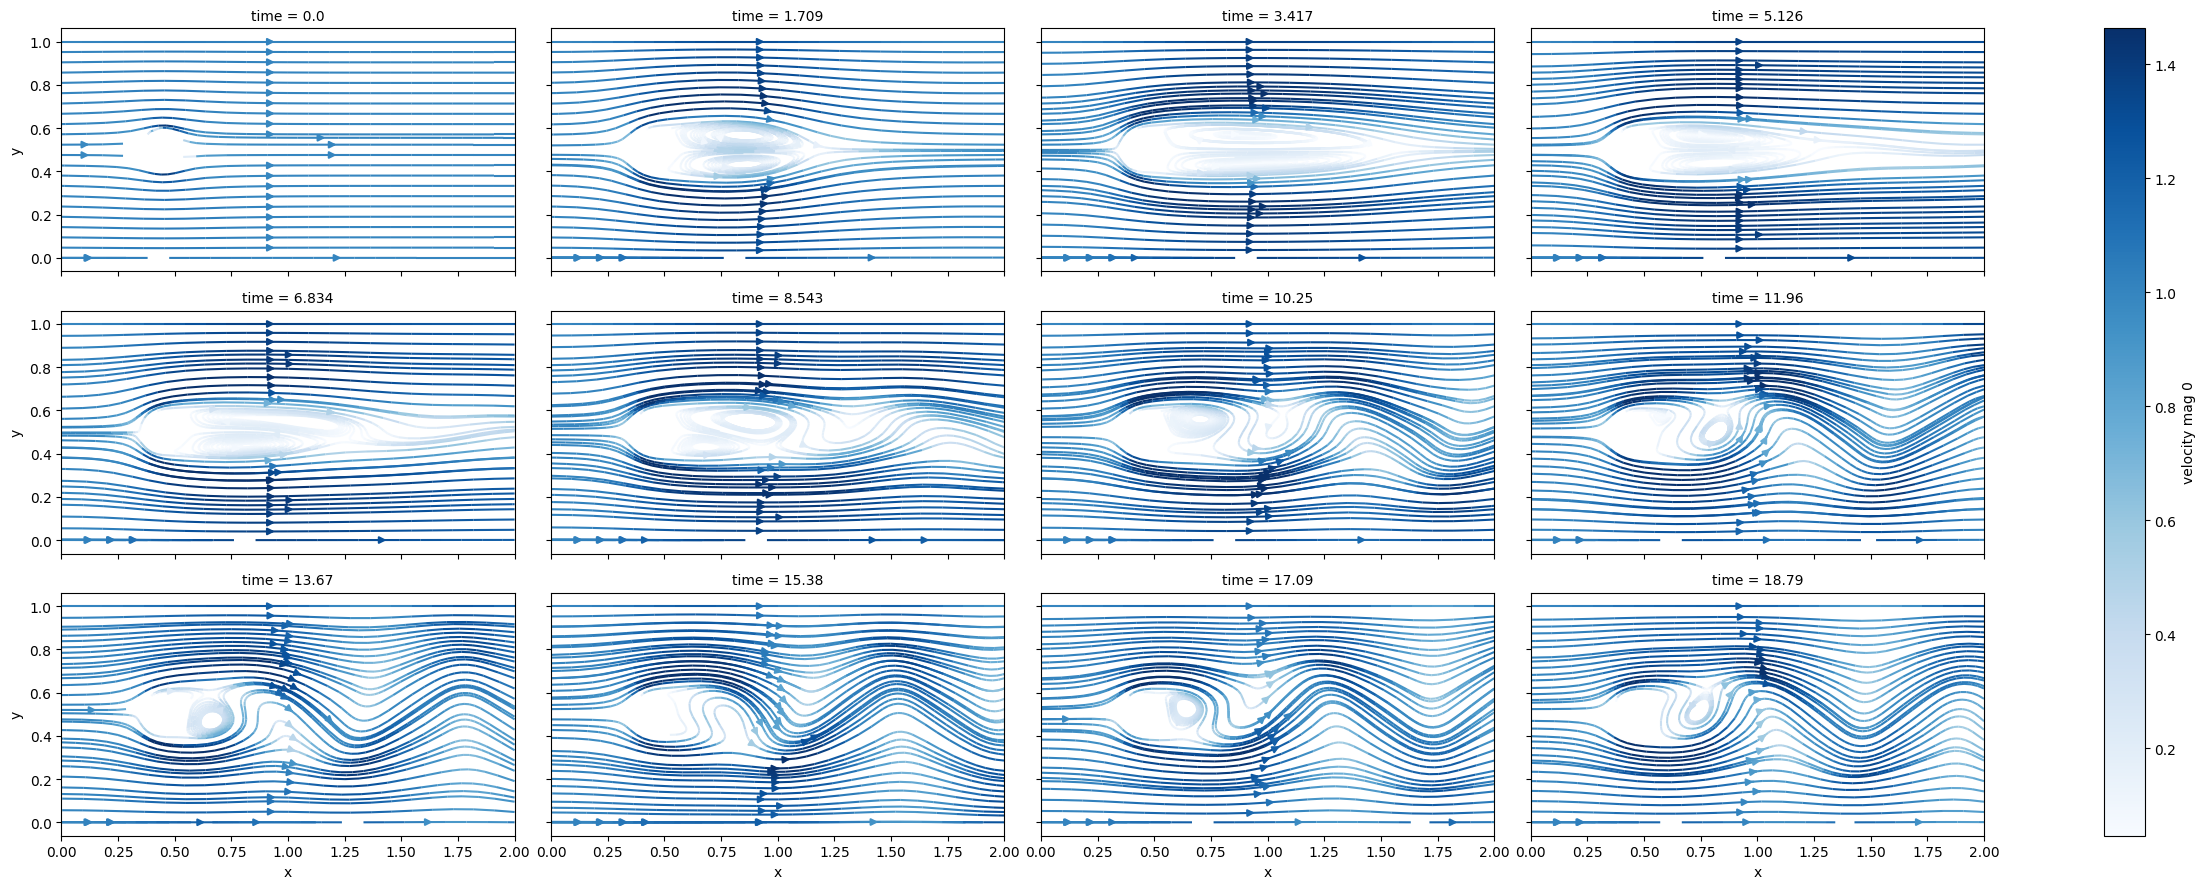

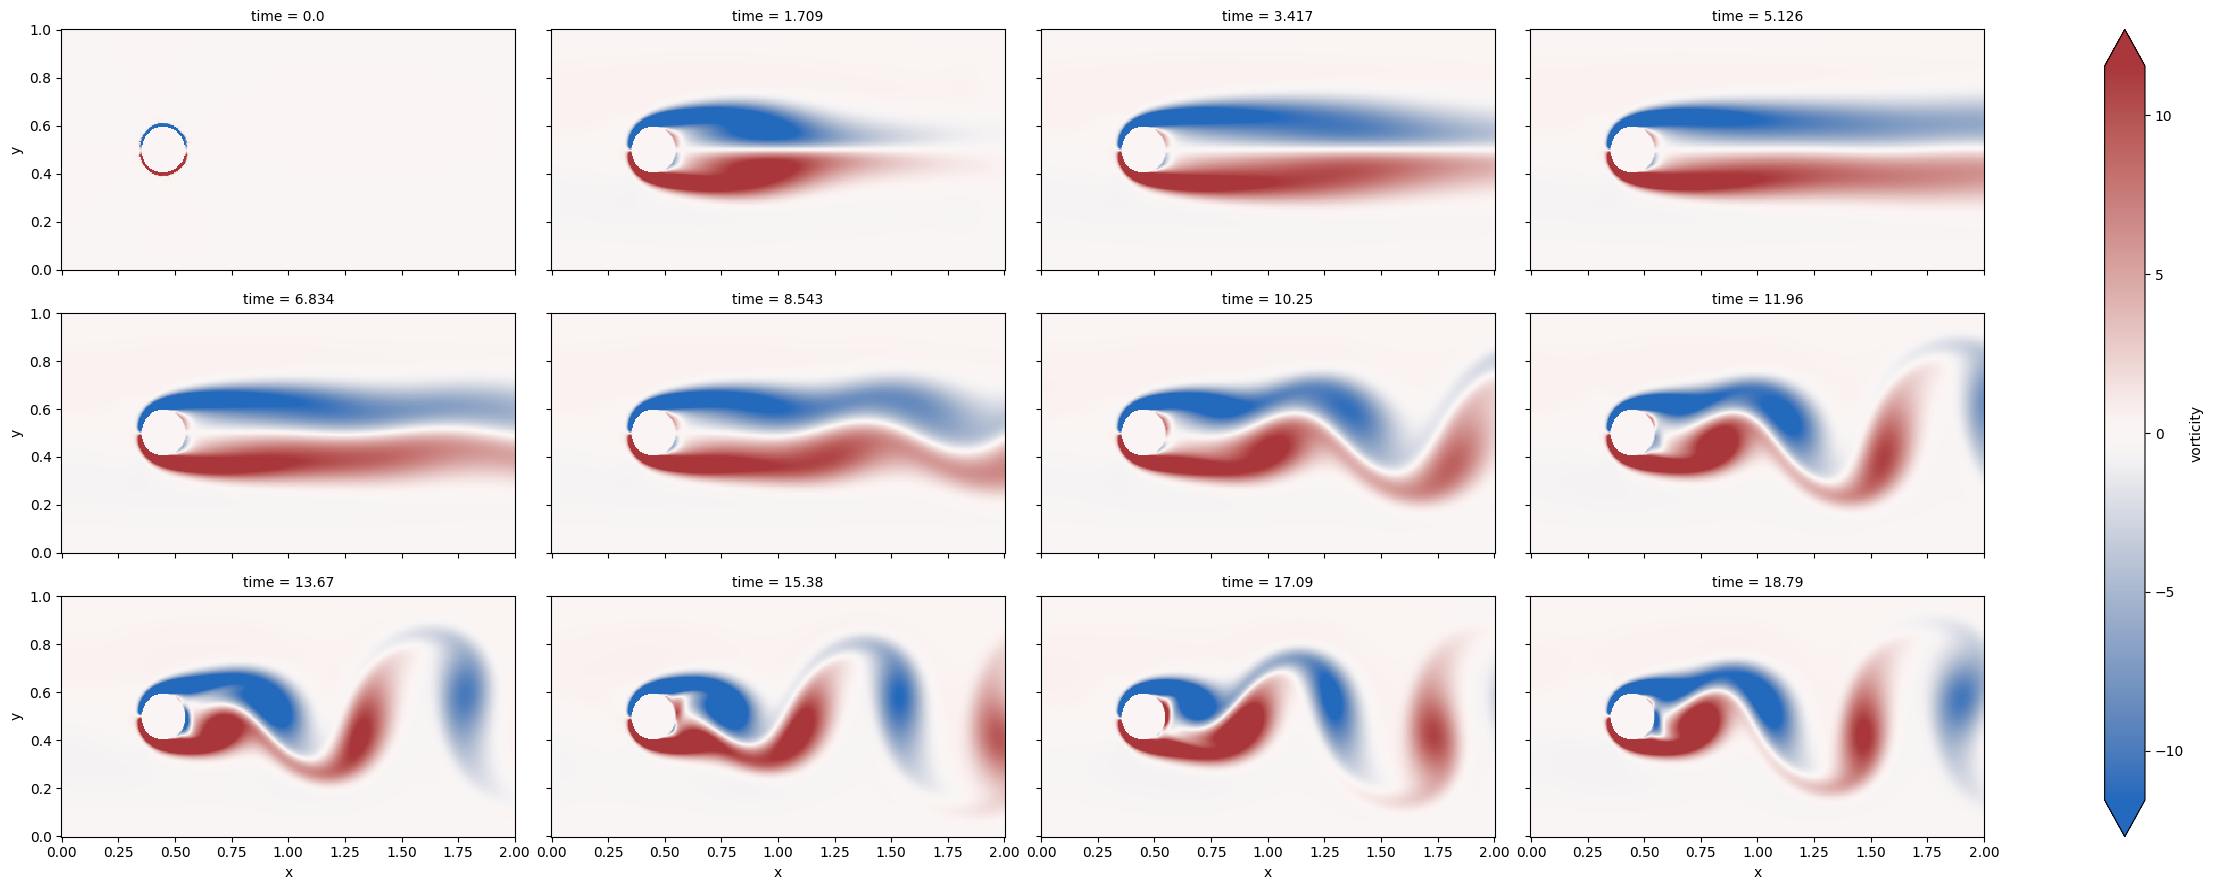

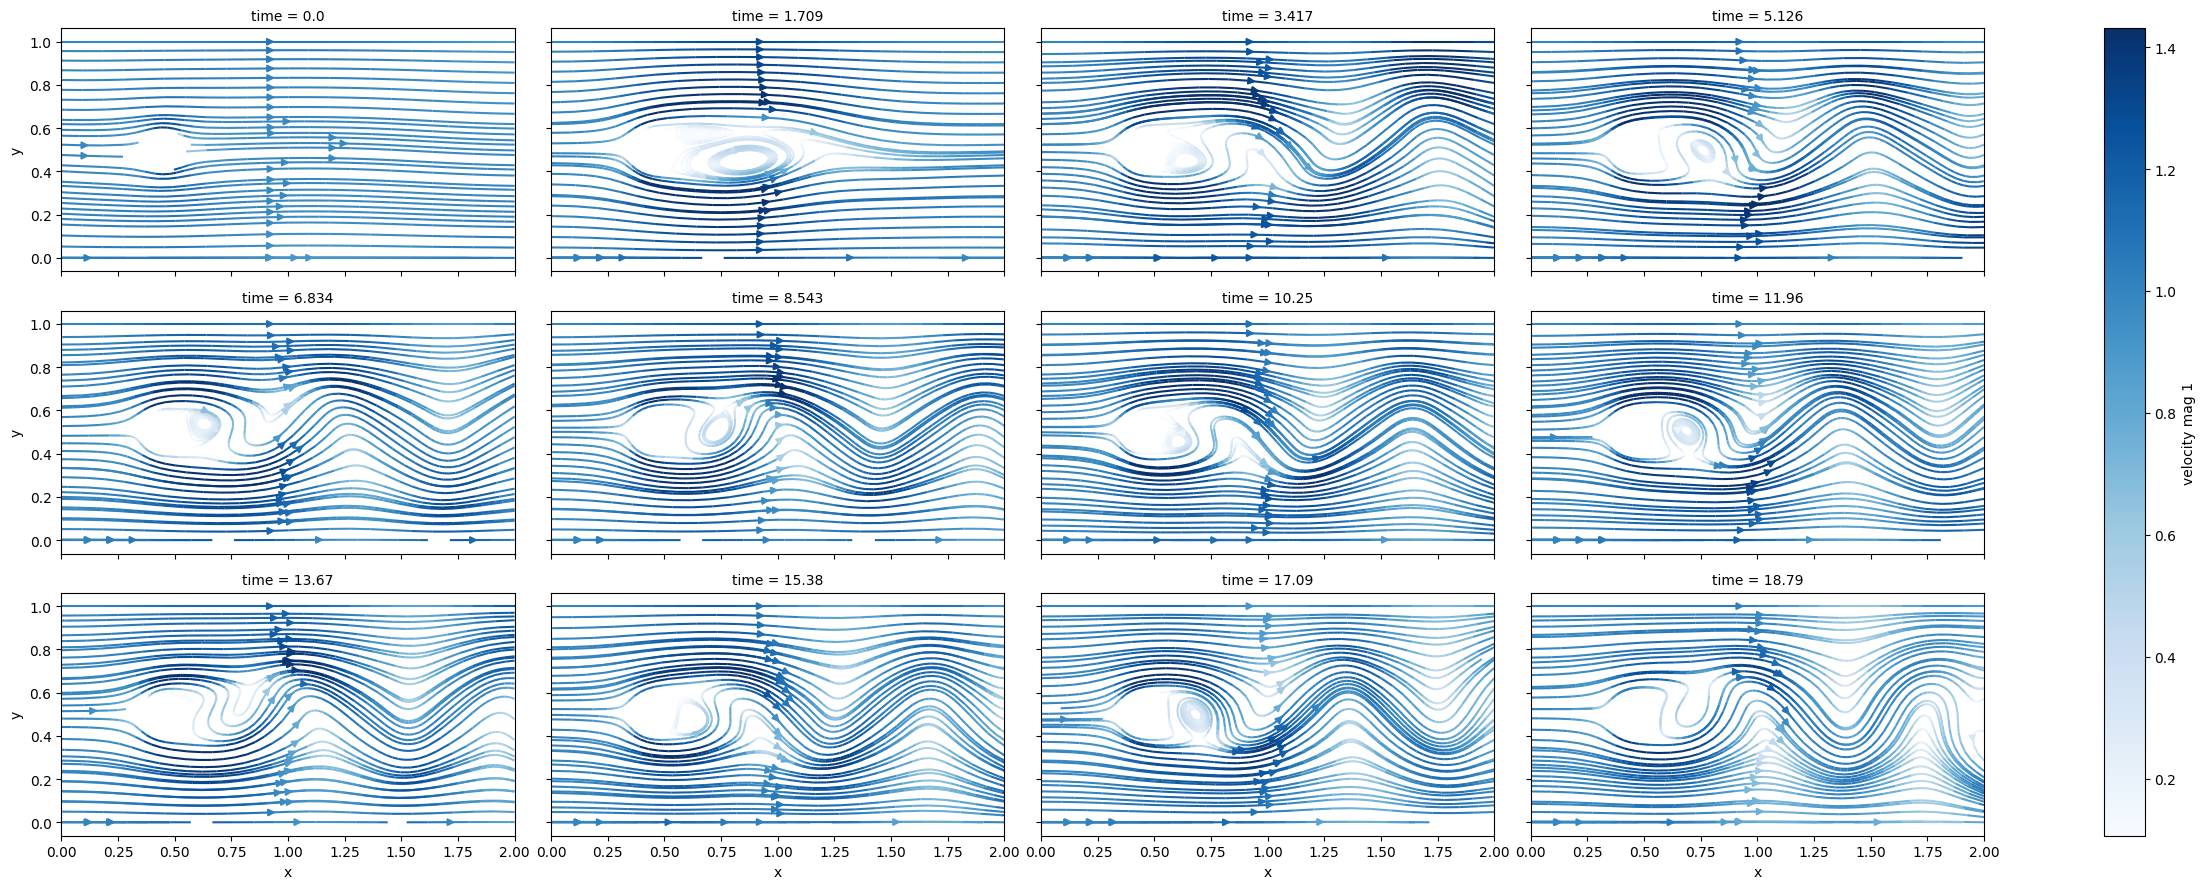

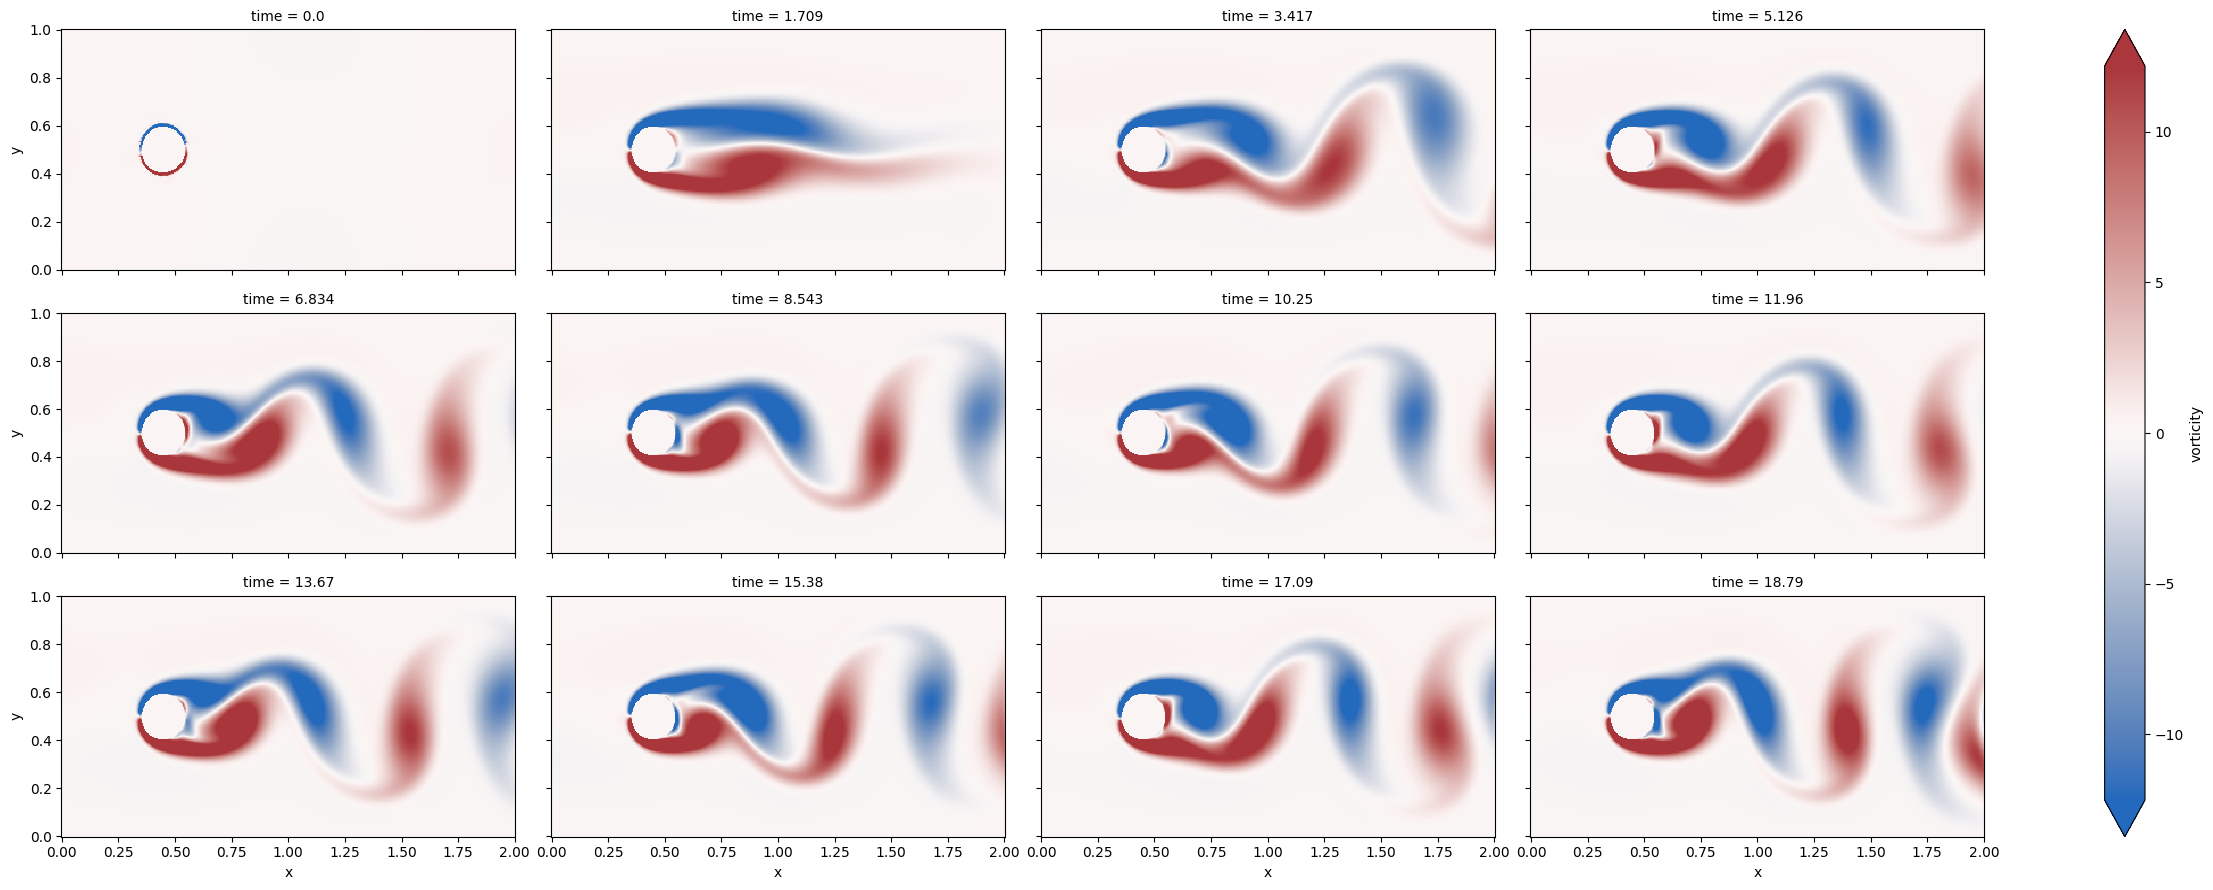

In [11]:
trajectory_plot = np.stack(trajectory).astype(np.float64)

idxes = [0, 1]
num_snapshot = 12
every_n_steps = math.ceil(num_steps/num_snapshot/update_steps)
def vorticity(ds):
    return (ds.v.differentiate("x") - ds.u.differentiate("y")).rename("vorticity")


coords = {
    "time": np.linspace(0, T, trajectory_plot.shape[1], dtype=np.float64),
    "x": np.linspace(0, 2, nx, dtype=np.float64),
    "y": np.linspace(0, 1, ny, dtype=np.float64),
}

for idx in idxes:
    u_data = xarray.DataArray(
        trajectory_plot[0, :, idx], dims=["time", "x", "y"], coords=coords
    ).to_dataset(name="u")

    v_data = xarray.DataArray(
        trajectory_plot[1, :, idx], dims=["time", "x", "y"], coords=coords
    ).to_dataset(name="v")

    velocity_mag = np.sqrt((trajectory_plot[:, :, idx] ** 2).sum(axis=0))

    vmag_data = xarray.DataArray(
        velocity_mag, dims=["time", "x", "y"], coords=coords
    ).to_dataset(name=f"velocity mag {idx}")

    data = xarray.merge([u_data, v_data, vmag_data]).assign(vorticity=vorticity)

    plot_velocity = data.thin(time=every_n_steps).plot.streamplot(
        x="x",
        y="y",
        u="u",
        v="v",
        hue=f"velocity mag {idx}",
        col="time",
        col_wrap=4,
        robust=True,
        cmap=sns.color_palette("Blues", as_cmap=True),
        aspect=2,
        density=0.75,
        broken_streamlines=False,
    )
    
    plot_vorticity = data['vorticity'].T.thin(time=every_n_steps).plot.imshow(
    robust=True,
    col="time",
    col_wrap=4,
    aspect=2,
    cmap=sns.cm.vlag,
)
